In [23]:
#check gpu
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())


2.8.0
True


In [24]:
# Import libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tqdm import tqdm
import matplotlib.pyplot as plt 

In [25]:
# 1. Load and Preprocess Data
csv_path = 'data-vn-20230228\stock-historical-data'

keywords = [
    "ABB", "ACB", "BID", "CTG", "EIB", "BVB", "HDB", "KLB", "LPB", "MBB", "MSB",
    "NAB", "BAB", "NVB", "OCB", "PGB", "SSB", "SGB", "SHB", "STB", "TCB", "TPB",
    "VAB", "VCB", "VIB", "VPB", "VBB"
]

# Load data
df_list = []
for file in os.listdir(csv_path):
    if any(keyword in file for keyword in keywords) and file.endswith('.csv'):
        file_path = os.path.join(csv_path, file)
        data = pd.read_csv(file_path, on_bad_lines='skip').dropna()
        data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
        df_list.append(data)

# Add Technical Indicators
def add_technical_indicators(df):
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

df_list = [add_technical_indicators(df) for df in df_list]

# Split into Train, Validation, and Test Sets
split_date_train = pd.Timestamp('2020-01-01')
split_date_val = pd.Timestamp('2021-01-01')

df_train_list, df_val_list, df_test_list = [], [], []
for df in df_list:
    train = df.loc[df['TradingDate'] < split_date_train]
    temp_test = df.loc[df['TradingDate'] >= split_date_train]
    val = temp_test.loc[temp_test['TradingDate'] < split_date_val]
    test = temp_test.loc[temp_test['TradingDate'] >= split_date_val]
    df_train_list.append(train)
    df_val_list.append(val)
    df_test_list.append(test)

C:\Users\nhata\AppData\Local\Temp\ipykernel_6420\4179341719.py:16: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_6420\4179341719.py:16: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_6420\4179341719.py:16: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_6420\4179341719.py:16: UserWarning: Pa

In [26]:
# 2. Prepare Time Window Data
def create_time_window_samples(df_list, window_size=30):
    X_data, y_data = [], []
    for df in tqdm(df_list, desc="Processing DataFrames"):
        for i in range(len(df) - window_size):
            window = [df.iloc[i+j, 1:6].values for j in range(window_size)]  # Open, High, Low, Close, Volume
            label = df.iloc[i + window_size, 1]  # Open Price as label
            X_data.append(window)
            y_data.append(label)
    return np.array(X_data), np.array(y_data)

window_size = 30
X_train, y_train = create_time_window_samples(df_train_list, window_size)
X_val, y_val = create_time_window_samples(df_val_list, window_size)
X_test, y_test = create_time_window_samples(df_test_list, window_size)

# Min-Max Normalize Data
def min_max_normalize(X_data, y_data=None):
    X_norm = np.zeros_like(X_data)
    y_norm = np.zeros_like(y_data) if y_data is not None else None
    X_min_max, y_min_max = [], []

    for i in range(len(X_data)):
        sample_min_max = []
        for j in range(X_data.shape[2]):
            min_val, max_val = X_data[i, :, j].min(), X_data[i, :, j].max()
            sample_min_max.append((min_val, max_val))
            X_norm[i, :, j] = (X_data[i, :, j] - min_val) / (max_val - min_val) if max_val > min_val else 0
        X_min_max.append(sample_min_max)
        if y_data is not None:
            min_label, max_label = min(X_data[i, :, 0]), max(X_data[i, :, 0])  # Use Open Price
            y_norm[i] = (y_data[i] - min_label) / (max_label - min_label) if max_label > min_label else 0
            y_min_max.append((min_label, max_label))
    return X_norm, y_norm, X_min_max, y_min_max

X_train_norm, y_train_norm, X_train_min_max, y_train_min_max = min_max_normalize(X_train, y_train)
X_val_norm, y_val_norm, X_val_min_max, y_val_min_max = min_max_normalize(X_val, y_val)
X_test_norm, y_test_norm, X_test_min_max, y_test_min_max = min_max_normalize(X_test, y_test)


Processing DataFrames: 100%|██████████| 27/27 [00:18<00:00,  1.49it/s]


In [27]:
#  convert to tensor
X_train_norm = tf.convert_to_tensor(X_train_norm, dtype=tf.float32)
y_train_norm = tf.convert_to_tensor(y_train_norm, dtype=tf.float32)
X_val_norm = tf.convert_to_tensor(X_val_norm, dtype=tf.float32)
y_val_norm = tf.convert_to_tensor(y_val_norm, dtype=tf.float32)
X_test_norm = tf.convert_to_tensor(X_test_norm, dtype=tf.float32)
y_test_norm = tf.convert_to_tensor(y_test_norm, dtype=tf.float32)

In [28]:
# Define the Conv1D model with Sigmoid Output
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, X_train_norm.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for probability output
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define binary labels for buy signals
# A buy signal is generated if the next day's price is higher than the average of the past window
y_train_binary = (y_train > np.mean(X_train[:, :, 0], axis=1)).astype(int)
y_val_binary = (y_val > np.mean(X_val[:, :, 0], axis=1)).astype(int)
y_test_binary = (y_test > np.mean(X_test[:, :, 0], axis=1)).astype(int)

# Train the model
history = model.fit(
    X_train_norm, y_train_binary,
    validation_data=(X_val_norm, y_val_binary),
    epochs=20, batch_size=2048
)

# Make predictions
y_pred_prob = model.predict(X_test_norm).flatten()
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 28, 64)            1024      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               114816    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

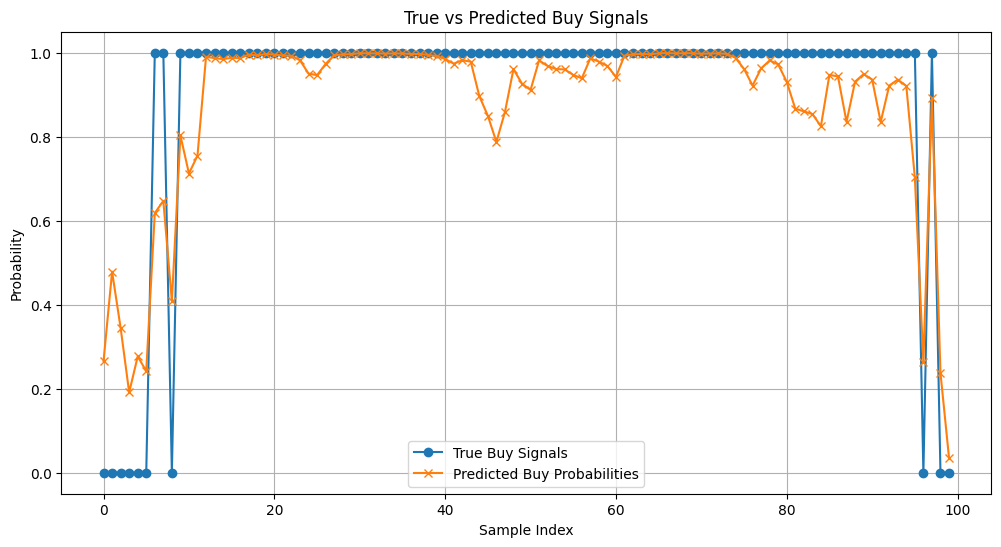

In [29]:
# 4. Visualization
plt.figure(figsize=(12, 6))
plt.plot(range(100), y_test_binary[:100], label='True Buy Signals', marker='o')
plt.plot(range(100), y_pred_prob[:100], label='Predicted Buy Probabilities', marker='x')
plt.title("True vs Predicted Buy Signals")
plt.xlabel("Sample Index")
plt.ylabel("Probability")
plt.legend()
plt.grid()
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluation Metrics:
Accuracy: 0.9306
Precision: 0.9328
Recall: 0.9263
F1 Score: 0.9295
